## Programming Exercise 2: Logistic Regression
El trabajo nos ofrece dos base de datos.
La primera trata de calificaciones en dos examenes de admisión en una universidad, y ademas nos entrega el resultado de la admisión (1 = admitido en la universidad, 0 = no admitido). La idea es poder extraer los datos, y calcular los parametros optimos para un modelo de regresion logistica que pueda predecir la admisión/no admisión de un alumno con fundamentos en sus clasificaciones en los examenes.

In [149]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 1 Logistic Regression

In [150]:
#El dataset
datafile = 'ex2data1.txt'
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True)
#Matriz x, matriz y
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
#Numero de datos
m = y.size
#Insertar columna de 1's
X = np.insert(X,0,1,axis=1)

#### 1.1 Visualizar la data

In [151]:
#Dividir los datos entre los admitidos y los rechazados
adm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
noAdm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

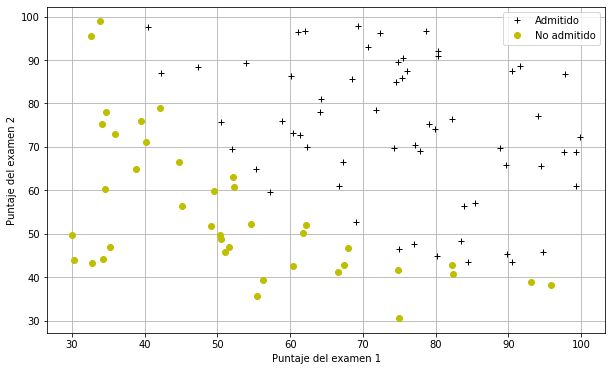

In [152]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(adm[:,1],adm[:,2],'k+',label='Admitido')
    plt.plot(noAdm[:,1],noAdm[:,2],'yo',label='No admitido')
    plt.xlabel('Puntaje del examen 1')
    plt.ylabel('Puntaje del examen 2')
    plt.legend()
    plt.grid(True)
    
plotData()

#### 1.2 Implementacion

#### Funcion hipotesis
$$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{- \theta^Tx} }  $$ 
#### Funcion de costo
$$  J (\theta) =\frac{1}{m}\sum_{i=1}^{m} [-y^{(i)}log(h_ \theta (x^{(i)})) - (1-y^{(i)})log(1-h_ \theta (x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n} \theta^2_j $$

In [153]:
#Funcion Sigmoid
from scipy.special import expit

In [154]:
#Funcion hipotesis (H) y funcion de costo (J)
def h(mytheta,myX): 
    return expit(np.dot(myX,mytheta))

def computeCost(mytheta,myX,myy,mylambda = 0.): 
    """
    X matriz de n-filas y m-columnas
    theta es una matriz de m-filas y 1 columna
    y es una matrix with m-filas y una columna
    Note: esta funcion incluye lambda, que sera utilizado para regularizar la funcion,
    se usara en la segunda parte de la presentación
    """
    term1 = np.dot(-np.array(myy).T,np.log(h(mytheta,myX)))
    term2 = np.dot((1-np.array(myy)).T,np.log(1-h(mytheta,myX)))
    regterm = (mylambda/2) * np.sum(np.dot(mytheta[1:].T,mytheta[1:]))
    #term1 y term2 son matrices 1x1, por eso np.sum
    J = float((1./m) * (np.sum(term1 - term2) + regterm))  
    return J

In [155]:
#Iniciar theta matriz de ceros, resultado esperado: J = 0.693
initial_theta = np.zeros((X.shape[1],1))

#Lambda = 0 (sin regularización)
computeCost(initial_theta,X,y)

0.6931471805599453

In [156]:
#La alternativa de OCTAVE "fminunc" es "fmin" de scipy.optimize
#"fmin" no necesita recibir la derivada de la funcion
#Minimiza la funcion (la funcion costo en este caso) con "downhill simplex algorithm".
#http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    """
    Devuelve una lista, el primer termino es theta optimizado para el modelo, y el segundo
    es el costo minimo de la función
    """
    result = optimize.fmin(computeCost, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

In [157]:
theta, mincost = optimizeTheta(initial_theta,X,y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [158]:
#Se vuelve a calular el costo, pero esta vez con el theta optimizado con la funcion "optimizeTheta"
#Se espera un resultado de J = 0.203
print(computeCost(theta,X,y))

0.2034977015902151


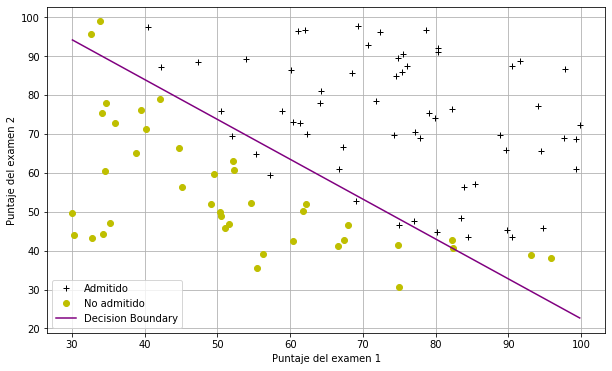

In [159]:
#Se grafican los "decision boundary"
#Los boundary suceden cuando h = 0.5 o cuando theta*X = 0
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b pasando los terminos x2 = (-1/thetheta2)(theta0 + theta1*x1)

boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./theta[2])*(theta[0] + theta[1]*boundary_xs)
plotData()
plt.plot(boundary_xs,boundary_ys,'b-',label='Decision Boundary', color = "purple", linewidth = 1.5)
plt.legend()
plt.show()

In [160]:
#Para un estudiante con puntajes de 45 y 85 deberia tener una probabilidad de aprobar de 0.776
print (h(theta,np.array([1, 45.,85.])))

0.7762915904112411


In [161]:
def makePrediction(mytheta, myx):
    return h(mytheta,myx) >= 0.5

#Calcular las predicciones realizadas correctamente
adm_correct = float(np.sum(makePrediction(theta,adm)))
noAdm_correct = float(np.sum(np.invert(makePrediction(theta,noAdm))))
tot = len(adm)+len(noAdm)
prcnt_correct = float(adm_correct+noAdm_correct)/tot
print ("Porcentaje de datos predecidos correctamente: %.2f." % prcnt_correct )

Porcentaje de datos predecidos correctamente: 0.89.


### 2 Regularized Logistic Regression
En la segunda parte vamos a verficar como van cambiando los "decision boundary" a medida que vamos modificando lambda, que es el termino que controla la regularizacion en la funcion de costo

#### 2.1 Visualizar la data

In [162]:
datafile = 'ex2data2.txt'
#Se importan los datos
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True) #Read in comma separated data
##Matriz x, matriz y
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
#Numero de entradas
m = y.size
##Se le agrega la columna de 1's a X
X = np.insert(X,0,1,axis=1)

In [163]:
#Dividir los datos entre los admitidos y los rechazados
adm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
noAdm = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

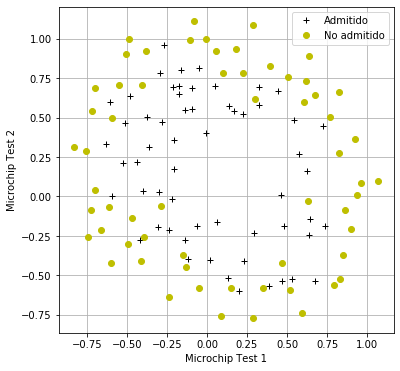

In [164]:
def plotData():
    plt.plot(adm[:,1],adm[:,2],'k+',label='Admitido')
    plt.plot(noAdm[:,1],noAdm[:,2],'yo',label='No admitido')
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(6,6))
plotData()

#### 2.2 Feature mapping

In [165]:
#El codigo toma X para formar una matriz de 28 elementos, conocido como "mapping":
#El mapping aumenta el numero de caracteristicas, para lograr un modelo que se ajuste mas a los datos.
#Esto se consigue creando mayor cantidad de variables independientes, elevando a potencias (en este caso de 6) 
#las variables ya existentes. 
#Esta practica puede llevar al modelo a "overfitting", que se corrige ajustando lambda

def mapFeature( x1col, x2col ):
    """ 
    Funcion que toma las columnas de X y las procesa elevandolas hasta la sexta potencia
    para formar una matriz de 28 columnas
    """
    degrees = 6
    out = np.ones((x1col.shape[0], 1))

    for i in range(1, degrees+1):
        for j in range(0, i+1):
            term1 = x1col ** (i-j)
            term2 = x2col ** (j)
            term  = (term1 * term2).reshape( term1.shape[0], 1 ) 
            out   = np.hstack(( out, term ))
    return out

In [166]:
#Ejecuto la regularizacion
mappedX = mapFeature(X[:,1],X[:,2])

#### 2.3 Cost function and gradient

In [167]:
#La funcion de costo es la misma de la parte 1
#Theta inicial ahora es una matriz de 28 columnas
#Verficar que J = 0.693 para theta = 0
initial_theta = np.zeros((mappedX.shape[1],1))
computeCost(initial_theta,mappedX,y)

0.6931471805599453

##### 2.3.1 Learning parameters using fminunc

In [168]:
def optimizeRegularizedTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.minimize(computeCost, mytheta, args=(myX, myy, mylambda),  
                               method='BFGS', options={"maxiter":500, "disp":False})
    return np.array([result.x]), result.fun
    
theta, mincost = optimizeRegularizedTheta(initial_theta,mappedX,y)

#### 2.4 Plotting the decision boundary

In [169]:
def plotBoundary(mytheta, myX, myy, mylambda=0.):
    """
    Funcion que grafica "decision boundary" con X,y y theta evaluados
    Dentro de la funcion misma, se mapea X y se calculan los thetas minimos, teniendo en cuenta lambda
    Funciona con x1 ("xvals") y x2 ("yvals") como puntos,
    Y para cada punto la funcion calcula si es True o False
    """
    theta, mincost = optimizeRegularizedTheta(mytheta,myX,myy,mylambda)
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))
    for i in range(len(xvals)):
        for j in range(len(yvals)):
            myfeaturesij = mapFeature(np.array([xvals[i]]),np.array([yvals[j]]))
            zvals[i][j] = np.dot(theta,myfeaturesij.T)
    zvals = zvals.transpose()
    u, v = np.meshgrid( xvals, yvals )
    mycontour = plt.contour( xvals, yvals, zvals, [0])
    
    #Texto sobre la "decision boundary"
    myfmt = { 0:'Lambda = %d'%mylambda}
    plt.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)

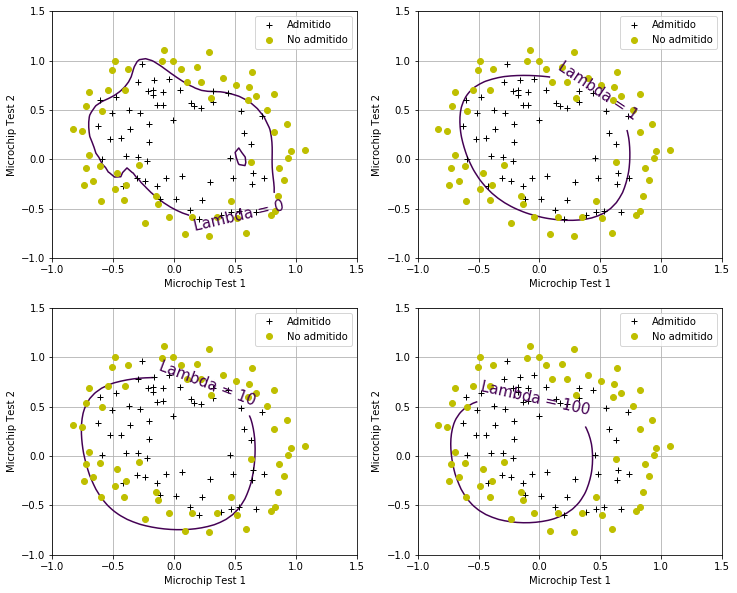

In [170]:
#Graficamos distintos "decision boundary" con sus respectivos lambdas
#Se ve que con lambda=0 el modelo esta "overfitting", y en lambda=100 esta "underfitting"
plt.figure(figsize=(12,10))

plt.subplot(221)
plotData()
plotBoundary(theta,mappedX,y,0.)

plt.subplot(222)
plotData()
plotBoundary(theta,mappedX,y,1)

plt.subplot(223)
plotData()
plotBoundary(theta,mappedX,y,10.)

plt.subplot(224)
plotData()
plotBoundary(theta,mappedX,y,100.)